In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [250]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.base import BaseEstimator, TransformerMixin # for feature construction by making class --method1
from sklearn.preprocessing import FunctionTransformer # for feature construction by making a single function ---method2

In [367]:
df=pd.read_csv('loan.csv')

In [368]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [369]:
# df['LoanAmount'].fillna(df['LoanAmount'].mean(),inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mean(),inplace=True)
# df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mean(),inplace=True)

C:\Users\ratho\AppData\Local\Temp\ipykernel_23520\1197785378.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Credit_History'].fillna(df['Credit_History'].mean(),inplace=True)


In [370]:
#pipeline ---- missing value imputation-> feature construction->handling categorical features->label encoding-> feature scaling->feature selection->model train

In [371]:
#feature transformation
df.drop(columns=['Loan_ID','LoanAmount','Loan_Amount_Term','Self_Employed'],inplace=True)

In [372]:
# Target variable
y = df["Loan_Status"]

# Encode target (Loan_Status: Y/N)
le = LabelEncoder()
y = le.fit_transform(y)

In [373]:
#spliting
x_train,x_test,y_train,y_test=train_test_split(df.drop(columns=['Loan_Status']),y,test_size=0.1)

In [374]:
x_train.head(3)

,Gender,Married,Dependents,Education,ApplicantIncome,CoapplicantIncome,Credit_History,Property_Area
211,Male,Yes,3+,Graduate,3430,1250.0,0.0,Semiurban
463,Female,No,1,Not Graduate,5191,0.0,1.0,Semiurban
231,Male,Yes,0,Graduate,3716,0.0,1.0,Rural


In [375]:
df.isnull().sum()
x_train.shape

(552, 8)

In [376]:
#one hot encoding to all categorical data because there's not a single column suitable for ordinal
trf3 = ColumnTransformer([
    ('ohe_allCatData', OneHotEncoder(drop='first',sparse_output=False, handle_unknown='ignore',dtype='int'), [0,1,2,3,7])
], remainder="passthrough")

In [377]:
#simpleImputer
trf1=ColumnTransformer(
    [('impute_gender',SimpleImputer(strategy='most_frequent'),[0]),
    ('impute_married',SimpleImputer(),[1]),
    ('impute_dependents',SimpleImputer(strategy='most_frequent'),[2])],
    remainder="passthrough"
)

In [378]:
#feature construction

# Custom feature constructor , this is by making class
# class FeatureConstructor(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         X = X.copy()
#         X['Total_Income'] = X['ApplicantIncome'] + X['CoapplicantIncome']
#         X['LoanAmount_per_month'] = (X['LoanAmount'] / X['Loan_Amount_Term'] * 1000)
#         X.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], axis=1, inplace=True)
#         return X
def feature_construction(X):
    X = X.copy()
    # here, replace with correct column indexes for ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term
    total_income = X[:, 5] + X[:, 6]
    # loan_amt_per_month = (X[:, 7] / X[:, 8]) * 1000
    X = np.delete(X, [5, 6,], axis=1)  # drop original cols
    X = np.column_stack([X, total_income])
    return X


In [379]:
# Scaling
trf4= ColumnTransformer([
    ('scale',MinMaxScaler(),slice(0,6))
])

In [380]:
# Feature selection
trf5= SelectKBest(score_func=chi2,k=5)

In [381]:
#model train
trf6= DecisionTreeClassifier()

In [382]:
#making pipeline

trf2=FunctionTransformer(feature_construction) 
pipe=Pipeline([
    ('trf3',trf3),
    ('trf1',trf1),
    ('trf2',trf2),
    ('trf4',trf4),
    ('trf5',trf5),
    ('trf6',trf6)
])

pipe.fit(x_train,y_train)

Pipeline(steps=[('trf3',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_allCatData',
                                                  OneHotEncoder(drop='first',
                                                                dtype='int',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [0, 1, 2, 3, 7])])),
                ('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute_gender',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [0]),
                                                 ('impute_married',
                                                  SimpleIm...1]),
                                                 ('impute_dependents',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [2])])),
                ('trf2',
                 FunctionTransformer(func=<function feature_construction at 0x0000016795CDA480>)),
                ('trf4',
                 ColumnTransformer(transformers=[('scale', MinMaxScaler(),
                                                  slice(0, 6, None))])),
                ('trf5',
                 SelectKBest(k=5,
                             score_func=<function chi2 at 0x00000167849EC180>)),
                ('trf6', DecisionTreeClassifier())])

In [383]:
#explore pipeline
pipe.named_steps

{'trf3': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe_allCatData',
                                  OneHotEncoder(drop='first', dtype='int',
                                                handle_unknown='ignore',
                                                sparse_output=False),
                                  [0, 1, 2, 3, 7])]),
 'trf1': ColumnTransformer(remainder='passthrough',
                   transformers=[('impute_gender',
                                  SimpleImputer(strategy='most_frequent'), [0]),
                                 ('impute_married', SimpleImputer(), [1]),
                                 ('impute_dependents',
                                  SimpleImputer(strategy='most_frequent'),
                                  [2])]),
 'trf2': FunctionTransformer(func=<function feature_construction at 0x0000016795CDA480>),
 'trf4': ColumnTransformer(transformers=[('scale', MinMaxScaler(), slice(0, 6, None))]),
 'trf5': Selec

In [384]:
# Display Pipeline

from sklearn import set_config
set_config(display='diagram')

In [385]:
# Predict
y_pred = pipe.predict(x_test)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [386]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.6451612903225806

In [387]:
y_test.shape

(62,)

In [388]:
y_test

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1])

In [389]:
# cross validation using cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, x_train, y_train, cv=10, scoring='accuracy').mean()

np.float64(0.6702272727272727)

C:\Users\ratho\AppData\Local\Temp\ipykernel_23520\3335835047.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x_train['ApplicantIncome'])


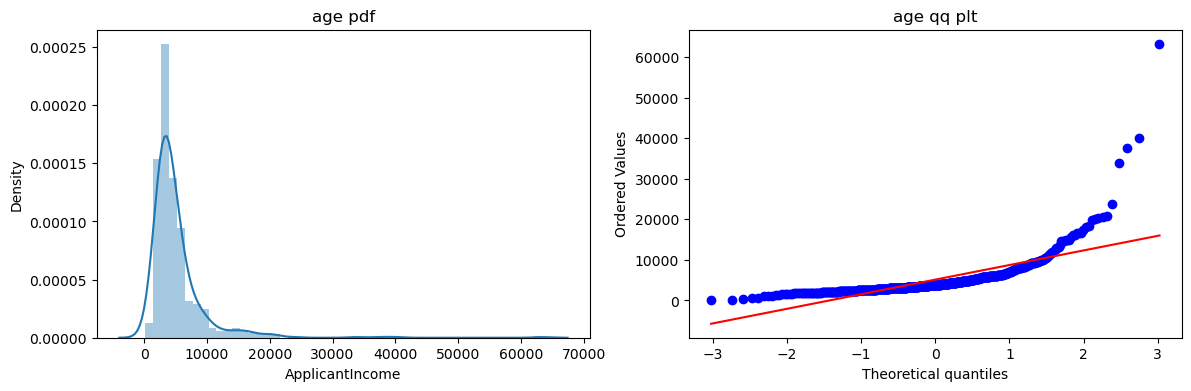

In [391]:
import scipy.stats as stats
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(x_train['ApplicantIncome'])
plt.title('age pdf')

plt.subplot(122)
stats.probplot(x_train['ApplicantIncome'],dist='norm',plot=plt)
plt.title('age qq plt')
plt.show()

In [392]:
pd.get_dummies(x_train,columns=['Gender','Married','Dependents','Education','Property_Area'],drop_first=True).astype('int32')

,ApplicantIncome,CoapplicantIncome,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Property_Area_Semiurban,Property_Area_Urban
211,3430,1250,0,1,1,0,0,1,0,1,0
463,5191,0,1,0,0,1,0,0,1,1,0
231,3716,0,1,1,1,0,0,0,0,0,0
381,5941,4232,1,1,0,0,0,0,0,1,0
543,2239,2524,1,1,1,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
119,10408,0,1,0,0,0,0,0,0,0,1
474,5532,4648,1,1,0,0,1,0,0,0,0
249,1809,1868,1,1,1,0,0,0,0,0,1
353,5500,0,0,0,1,0,0,0,0,0,0


C:\Users\ratho\AppData\Local\Temp\ipykernel_23520\664336498.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x_train['Dependents'])


ValueError: could not convert string to float: '3+'

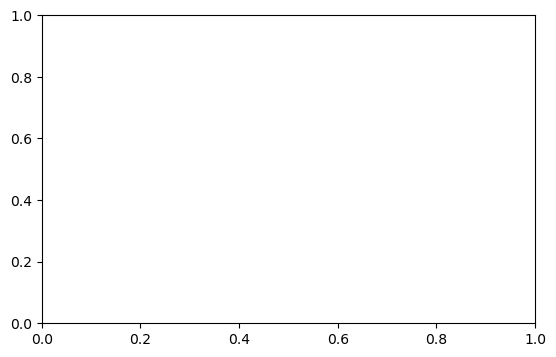

In [393]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(x_train['Dependents'])
plt.title('age pdf')

plt.subplot(122)
stats.probplot(x_train['Dependents'],dist='norm',plot=plt)
plt.title('age qq plt')
plt.show()